In [1]:
import jax
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from itertools import count
import jax.random as jr
import jax.scipy as jsci
from jax import jit,vmap, lax
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from functools import partial
from utils import *
from plotting_utils import *
from inference_and_sample import *
import task_subspace_LDS



keys = map(jr.PRNGKey, count())

In [2]:
print("jax:", jax.__version__)
print("devices:", jax.devices())
print("default backend:", jax.default_backend())

# !nvidia-smi

jax: 0.5.3
devices: [CudaDevice(id=0)]
default backend: gpu


In [3]:
# hyperparameters
D = 50
K1 = 3
K2 = K1
K = K1+K2
I = 2

S = 200
T = 100

In [4]:
M, N = generate_low_rank_matrix(K1, D, next(keys))
W = M @ N.T

[ 0.884 +0.j     0.1909+0.523j  0.1909-0.523j  0.    +0.j
  0.    +0.j     0.    +0.j     0.    -0.j    -0.    +0.j
 -0.    -0.j    -0.    +0.j    -0.    +0.j    -0.    -0.j
  0.    +0.j     0.    -0.j     0.    +0.j     0.    -0.j
  0.    +0.j     0.    -0.j    -0.    +0.j    -0.    -0.j
 -0.    +0.j    -0.    -0.j    -0.    +0.j    -0.    -0.j
  0.    +0.j     0.    -0.j     0.    +0.j     0.    -0.j
  0.    +0.j     0.    -0.j    -0.    +0.j    -0.    +0.j
 -0.    -0.j     0.    +0.j     0.    -0.j    -0.    +0.j
 -0.    -0.j     0.    +0.j     0.    -0.j    -0.    +0.j
 -0.    -0.j    -0.    +0.j    -0.    -0.j     0.    +0.j
  0.    +0.j    -0.    +0.j    -0.    -0.j     0.    +0.j
  0.    -0.j    -0.    +0.j   ]


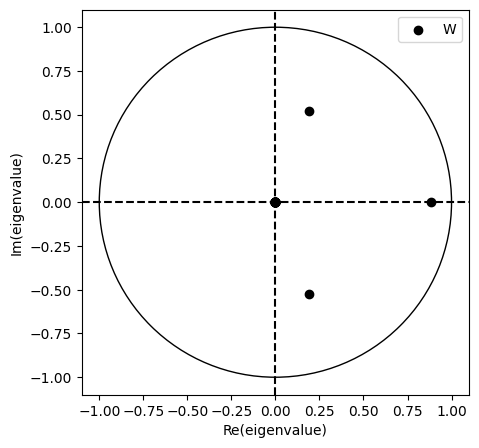

In [5]:
fig, axes = plt.subplots(figsize=(5,5))
eigW = jnp.linalg.eigvals(W)
axes.scatter(jnp.real(eigW), jnp.imag(eigW), color='black', label='W', marker='o')
axes.set_xlabel('Re(eigenvalue)')
axes.set_ylabel('Im(eigenvalue)')
circle1 = plt.Circle((0, 0), 1, color='black', fill=False)
axes.add_patch(circle1)
axes.axvline(0, linestyle='dashed', color='black')
axes.axhline(0, linestyle='dashed', color='black')
axes.legend()

In [6]:
# permute columns of M and N so that A is not necessarily 2 x 2 diagonal block matrix, but maintains same eigenvalues
key = jax.random.PRNGKey(1)
perm = jax.random.permutation(key, M.shape[1])  # length = num cols
print(perm)
M = M[:, perm]
N = N[:,perm]

[2 0 1]


In [7]:
# note M and N are orthogonal subspace to each other (which means U_M/N = U_M)
# find orthogonal subspace of col(M) and col(N)
U_M, _, _ = jnp.linalg.svd(M, full_matrices=False)
U_N, _, _ = jnp.linalg.svd(N, full_matrices=False)
A11 = U_N.T @ M @ N.T @ U_N
A21 = U_M.T @ M @ N.T @ U_N

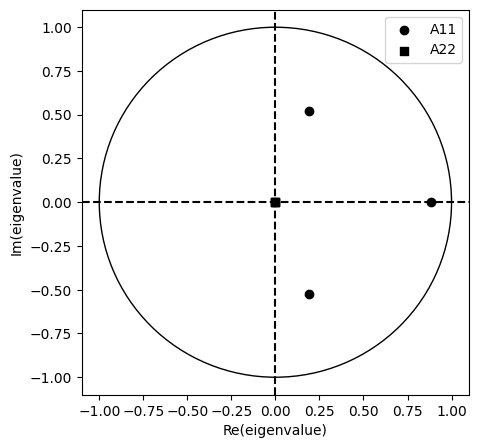

In [8]:
A22 = jnp.zeros((K2,K2))
A12 = jnp.zeros((K1,K2))

trueA = jnp.block([[A11, A12],[A21, A22]])


fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, jnp.linalg.eigvals(A11), jnp.linalg.eigvals(A22), color='black', label=['A11','A22'], alpha=1)
axes.legend()



In [10]:
LDS = task_subspace_LDS.task_subspace_LDS(D, K1, K2, I)
trueu = LDS.generate_inputs(next(keys), S, T)
trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR = LDS.generate_other_parameters(next(keys), trueA)

In [11]:
# x_single, y_single = generate_latents_and_observations(next(keys), trueu[0], trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [12]:
# whole sessions generation
keys_batch = jr.split(next(keys), S)
truex, truey = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [13]:
mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)
m, cov, cov_successive = Kalman_smoother_E_step_batches(trueA, mu, mu_prior, V, V_prior)

In [14]:
# Per-session stats (each with leading S axis)
sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

print(m.shape)

# Sum across sessions for every leaf
stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)
M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats

print(M_first.shape)

(200, 100, 6)
(6, 6)


In [15]:
# G_inv = jnp.linalg.inv(G)
# print(G)
# mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, G @ trueA @ G_inv, G @ trueB, G @ trueQ @ G.T, G @ truemu0, G @ trueQ0 @ G.T, trueC @ G_inv, trued, trueR)
# m, cov, cov_successive = Kalman_smoother_E_step_batches(G @ trueA @ G_inv, mu, mu_prior, V, V_prior)

# # Per-session stats (each with leading S axis)
# sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

# # Sum across sessions for every leaf
# stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)
# M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats


In [16]:
# to check that compute ECLL gives same value with transformed sufficient stats or not

In [23]:
# fit staring from true parameters
A, B, Q, mu0, Q0, C, d, R, _, _, _, ll_max, _ = LDS.fit_EM(trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=50)


In [24]:
print(ll_max[-1])

522.8478596669247


/tmp/ipykernel_42084/65121285.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc='upper left')


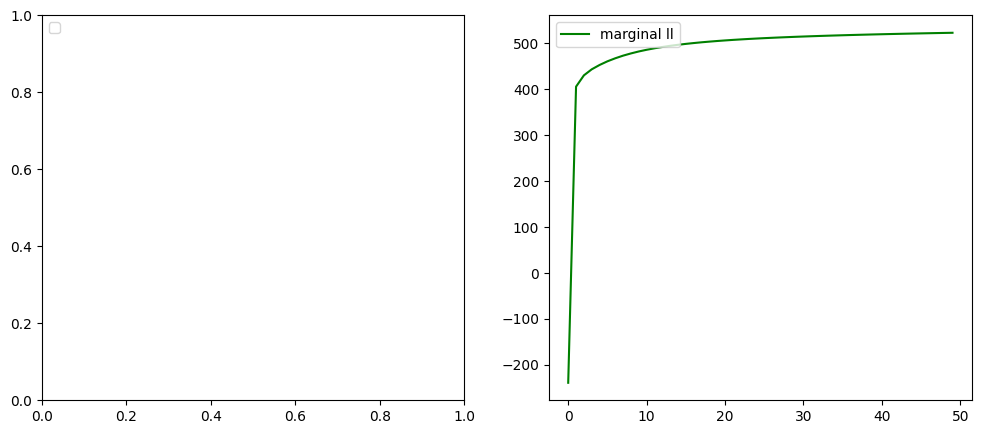

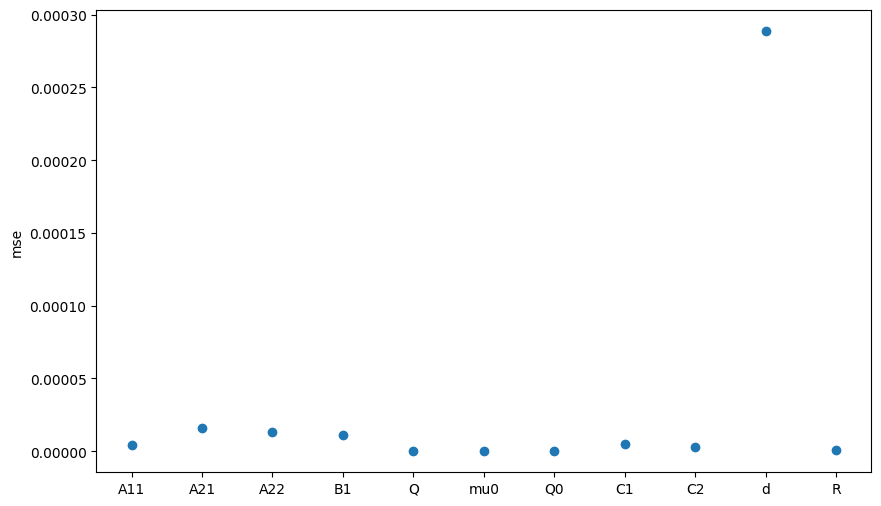

In [25]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[1].plot(ll_max, color='green', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

fig, axes = plt.subplots(figsize=(10,6))
plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

(50, 50)
0.9568622434098888
0.7010045151200996


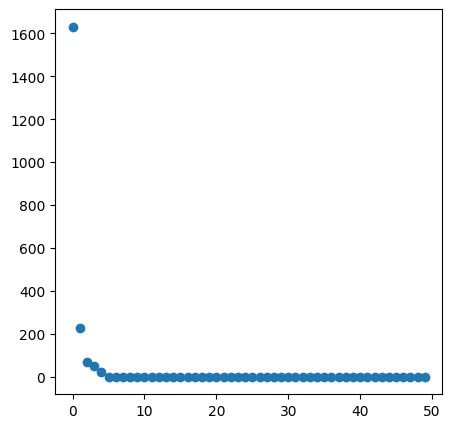

In [77]:
print((truey[0].T @ truey[0]).shape)

truey_pca = truey.mean(axis=0)
# print(truey_pca.mean(axis=0).shape)
truey_pca = truey_pca - truey_pca.mean(axis=0)

# SVD on Y^T Y is the same as PCA on Y
U, S, VT = jnp.linalg.svd(truey_pca.T @ truey_pca)  # U[:,:K] has K column vectors defining PCA space

# look at variance captured
fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(range(S.shape[0]), S)

print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC) / jnp.linalg.norm(trueC))
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))

print(jnp.linalg.norm(U[:,:K1] @ U[:,:K1].T @ trueC[:,:K1]) / jnp.linalg.norm(trueC[:,:K1]))
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))

In [ ]:
# try initialization from SSID

In [62]:
# A, B, Q, mu0, Q0, C, d, R, timing_log = LDS.fit_EM_timed(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR,max_iter=5, verbosity=0, print_every=1)
# print(timinglog[-1])

# # fit staring from true parameters
# A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll = LDS.fit_EM(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=300)

# fit starting from random init
initeigs1 = generate_eigenvalues(next(keys), K1, R=0.999, r=0.8)
initeigs2 = generate_eigenvalues(next(keys), K2, R=0.3, r=0.1)
initA = LDS.generate_dynamics_matrix(next(keys), initeigs1, initeigs2)
# initA = initA.at[K1,K1].set(0)
initB, initQ, initmu0, initQ0, initC, initd, initR = LDS.generate_other_parameters(next(keys), initA)
A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll, changes_param = LDS.fit_EM(trueu, truey, initA, initB, trueQ, truemu0, trueQ0, trueC, initd, initR, max_iter=2000)
# A, B, Q, mu0, Q0, C, d, R, ecll_new, ecll_old, elbo, ll, changes_param = LDS.fit_EM(trueu, truey, initA, initB, trueQ, truemu0, trueQ0, U[:,:K], initd, initR, max_iter=2500)

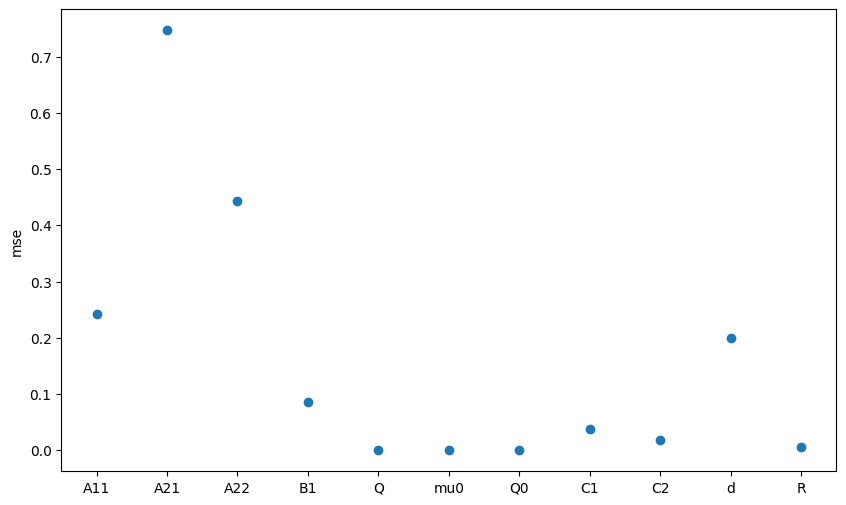

In [63]:
fig, axes = plt.subplots(figsize=(10,6))
plot_mse_parameters(axes, K1, A, B, Q, mu0, Q0, C, d, R, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [64]:
# print(C[:,0])
# print(trueC[:,0])

In [65]:
# print(B)
# print(trueB)

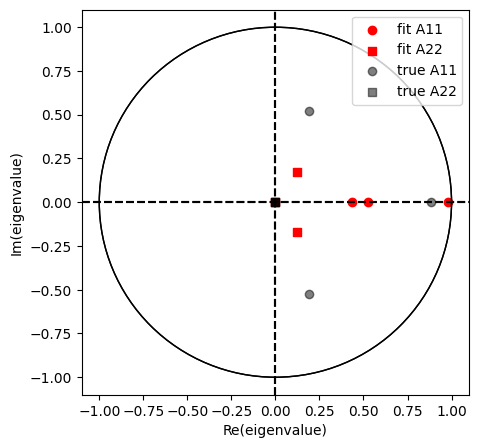

In [78]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, jnp.linalg.eigvals(A[:K1,:K1]), jnp.linalg.eigvals(A[K1:,K1:]), color='red', label=['fit A11','fit A22'], alpha=1)
plot_eigenvalues(axes, jnp.linalg.eigvals(A11), jnp.linalg.eigvals(A22), color='black', label=['true A11','true A22'], alpha=0.5)
axes.legend()

(-479231.25341853965, -2360.7450907317225)

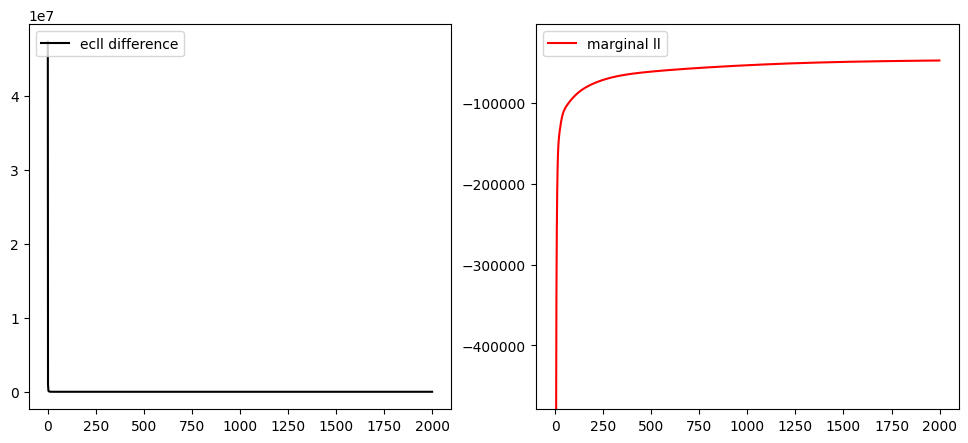

In [79]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll difference')
# axes[1].plot(elbo, color='purple', label='marginal ll')
# axes[1].axhline(ll_max[-1], color='green', label='best')
axes[1].plot(ll, color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
# axes[1].set_ylim(-ll_max[-1]*.15,ll_max[-1]*1.15)
axes[1].set_ylim(ll[-1]*10.15,ll[-1]*0.05)

Text(0, 0.5, 'norm of change in parameters')

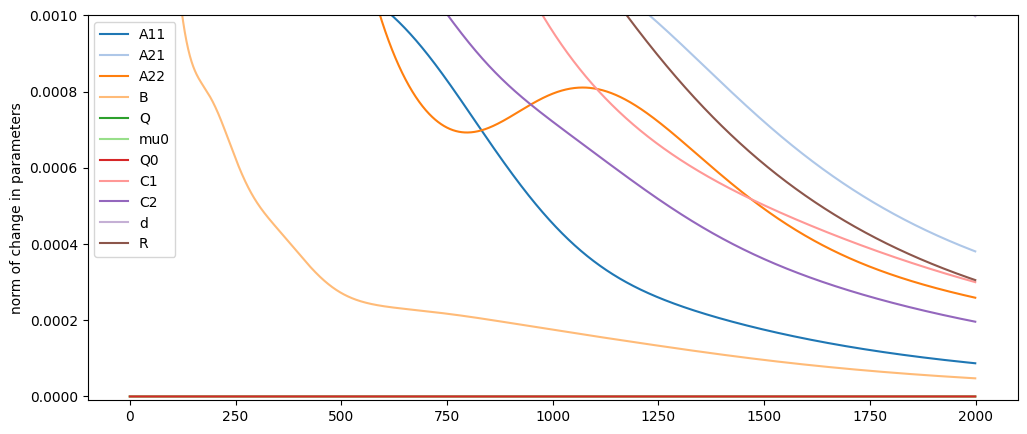

In [80]:
fig, axes = plt.subplots(1,figsize=(12,5))
import matplotlib as mpl
colors = mpl.colormaps['tab20'].colors 
# print(ll.sum(axis=1))
labels = ['A11', 'A21', 'A22', 'B', 'Q', 'mu0', 'Q0', 'C1','C2', 'd', 'R']
for z in range(11):
    axes.plot(changes_param[:,z], color=colors[z], label=labels[z])
axes.legend()
axes.set_ylim(-0.00001,0.001)
axes.set_ylabel('norm of change in parameters')
# axes[1].plot(elbo, color='purple', label='marginal ll')
# axes[1].axhline(ll_max[-1], color='green', label='best')
# axes[1].plot(ll, color='red', label='marginal ll')
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
# axes[1].set_ylim(ll[-1]*0.15,ll[-1]*1.05)

In [81]:
print(ll[-2]-ll[-1])
print(ll[-2]/ll[-1])

-2.2789577380899573
1.0000482677640004


In [82]:
# # function to check convergence of LDS:

# def check_convergence_EM(ll_prev,ll_current):
#     if ll_prev - ll_current < 
    
    

In [83]:
# checking alignment of fitted C1 has same subspace with generative one

import scipy.linalg as sl
print("C1")
print(jnp.rad2deg(sl.subspace_angles(trueC[:,:K1], C[:,:K1])))
print(jnp.linalg.norm(trueC[:,:K1] @ trueC[:,:K1].T @ C[:,:K1]) / jnp.linalg.norm(C[:,:K1]))

print("C2")
print(jnp.rad2deg(sl.subspace_angles(trueC[:,K1:], C[:,K1:])))
print(jnp.linalg.norm(trueC[:,K1:] @ trueC[:,K1:].T @ C[:,K1:]) / jnp.linalg.norm(C[:,K1:]))

C1
[48.85214929 37.07722754  7.48867066]
0.8473227851462871
C2
[85.7780681  36.29618114  9.16423614]
0.8562094592073213


In [26]:
# checking that PCA on y gives C space, in the very low noise case
truex_noR, truey_noR = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, 1e-15 * jnp.eye((D)))




In [ ]:
# checking that doing PCA on data gives back true C or orthogonalization of C (mean-center data to avoid d appearing too!!!)
print((truey[0].T @ truey[0]).shape)

truey_pca = truey.mean(axis=0)
# print(truey_pca.mean(axis=0).shape)
truey_pca = truey_pca - truey_pca.mean(axis=0)

# SVD on Y^T Y is the same as PCA on Y
U, S, VT = jnp.linalg.svd(truey_pca.T @ truey_pca)  # U[:,:K] has K column vectors defining PCA space

# look at variance captured
fig, axes = plt.subplots(figsize=(5,5))
axes.scatter(range(S.shape[0]), S)
print(S)


In [29]:
# checking alignment of C and PCA space (note: C is PCA space without the first dimension which represents d)
print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC) / jnp.linalg.norm(trueC))
# print(jnp.linalg.norm(U[:,:K] @ U[:,:K].T @ trueC - trueC))

import scipy.linalg as sl
print(jnp.rad2deg(sl.subspace_angles(U[:,:K], trueC)))


0.9967440068030905
[6.54173586 0.27730654]


In [ ]:
Uc, Sc, VTc = jnp.linalg.svd(trueC, full_matrices=False) # do SVD to get orthogonal susbpace in which C lives
print(Uc.shape)
print(jnp.linalg.norm(U[:,:K] - Uc))


4.1805132565062045e-06
2.2161201315601405e-06


(200, 99, 5, 5)


-1977063.9066138251
-806.304519230697
